In [2]:
# !pip install optuna

# Проект для "Викишоп" с BERT

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-данных-и-общая-информация" data-toc-modified-id="Импорт-данных-и-общая-информация-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт данных и общая информация</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка выборок</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Функции-построения-моделей" data-toc-modified-id="Функции-построения-моделей-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Функции построения моделей</a></span></li><li><span><a href="#Модель-LogisticRegression" data-toc-modified-id="Модель-LogisticRegression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель LogisticRegression</a></span></li><li><span><a href="#Модель-DecisionTreeClassifier" data-toc-modified-id="Модель-DecisionTreeClassifier-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Модель DecisionTreeClassifier</a></span></li><li><span><a href="#Модель-RandomForestClassifier" data-toc-modified-id="Модель-RandomForestClassifier-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Модель RandomForestClassifier</a></span></li><li><span><a href="#Модель-CatBoostClassifier" data-toc-modified-id="Модель-CatBoostClassifier-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Модель CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Проверка-лучшей-модели" data-toc-modified-id="Проверка-лучшей-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка лучшей модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

**Заказчик исследования:** интернет-магазин «Викишоп».  
**Цель исследования:** построить модель распознавания токсичных комментариев.

**Требования заказчика:** значение метрики F1 на тестовой выборке должно быть не меньше 0.75.

**Исходные данные:**  
Исходные данные представлены в датасете toxic_comments.csv:  

В датасете содержатся следующие признаки:  
- text (комментарий);  
- toxic (признак токсичности комментария).

**Используемые библиотеки:**

In [3]:
import re
import timeit

import numpy as np
import optuna
import pandas as pd
import torch
import matplotlib.pyplot as plt
import transformers as ppb

from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from optuna.distributions import FloatDistribution as floatd
from optuna.distributions import IntDistribution as intd
from optuna.integration import OptunaSearchCV
from pandarallel import pandarallel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from tqdm import notebook
from wordcloud import WordCloud

%matplotlib inline

## Импорт данных и общая информация
<a id="section_1"></a>

Загружаем датасет:

In [2]:
df = pd.read_csv('toxic_comments.csv', index_col=0)

In [3]:
def inf(df):
    '''функция получения общей информации'''
    print('Размер датафрейма:')
    print(df.shape)
    print('_' * 50)
    print()
    print('Общая информация о датафрейме:')
    print(df.info(memory_usage='deep'))
    print('_' * 50)
    print()
    print('Несколько строк датафрейма:')
    display(df.sample(random_state=0, n=5))
    print('_' * 50)
    print()
    print('Количество полных дубликатов:')
    print(df.duplicated().sum())
    print('_' * 50)  
    print('Количество признака "text":')
    print(df['text'].duplicated().sum())
    print('_' * 50)  
    print()
    print('Описательная статистика числовых значений:')
    display(df.describe().T)
    print('_' * 50)
    print()
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    print('Количество пропусков в процентах:')
    print(df.isna().mean()*100) 
    print('_' * 50)
    print()
    print('Доля токсичных комментариев - {:.3f}'.format(df["toxic"].sum()/df["toxic"].count()))

In [4]:
inf(df)

**Вывод:**  
1. Исходный датафрейм состоит из 159292 наблюдений и 3 признаков.  
2. Дублирование значений и пропуски отсутствуют.
3. Определено наличие дисбаланса классов: доля токсичных комментариев - 0.102;

## Исследовательский анализ данных

Создадим два облака слов - для токсичных и нетоксичных комментариев.

Обрабатываем комментарии - все удаляем символы, кроме буквенных (латиница):

In [5]:
def clear_text(text):
    
    import re                                                     # импорт библиотеки
    
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text).split()         # разделяем очищаем текст
    clear_text = ' '.join(clear_text)                             # объединяем текст
    return(clear_text)

In [6]:
pandarallel.initialize()
df['text'] = df['text'].parallel_apply(clear_text)

**Функции**

In [7]:
def plot_cloud(wordcloud):
    '''Функция для визуализации облака слов'''
    plt.figure(figsize=(40, 30))                        # Устанавливаем размер картинки
    plt.imshow(wordcloud)                               # Показать изображение
    plt.axis("off")                                     # Без подписей на осях

In [8]:
def cloud_params(data):
    '''Функция параметров облака слов'''
    text_for_cloud = " ".join(list(data['text_mod']))                          # объединяем комментарии в текст
    # параметры облака слов
    wordcloud = WordCloud(width = 2000,  
                          height = 1500, 
                          random_state=1, 
                          background_color='black', 
                          margin=20, 
                          colormap='Pastel1', 
                          collocations=False).generate(text_for_cloud)
    plot_cloud(wordcloud)                                                       # визуализируем облако слов

In [9]:
def text_modify(text):
    '''Функция обработки текста'''
    
    # импорт библиотек
    import nltk
    from nltk import word_tokenize
    from nltk.stem import WordNetLemmatizer
    from stop_words import get_stop_words
    
    stopwords_en = get_stop_words('english')                              # список стоп-слов
    wnl = WordNetLemmatizer()                                             # инициализируем лемматизатор
    text_token = word_tokenize(text)                                      # производим токенизацию
    text_lemma = [wnl.lemmatize(word.lower()) for word in text_token]                                       # производим лемматизацию
    text_stop_words = [word for word in text_lemma if (word not in stopwords_en) & (len(word) > 1)]         # удаляем стоп-слова
    text = nltk.Text(text_stop_words)                                     # список токенов преобразовываем к классу Text
    text_for_cloud = " ".join(text)                                       # объединяем в текст
    return(text_for_cloud)

**Создание облаков слов**

Поднртовка текста комментариев - токенизация, лематизация, удаление стоп-слов:

In [10]:
df['text_mod'] = df['text'].parallel_apply(text_modify)

Облако слов токсичных комментариев:

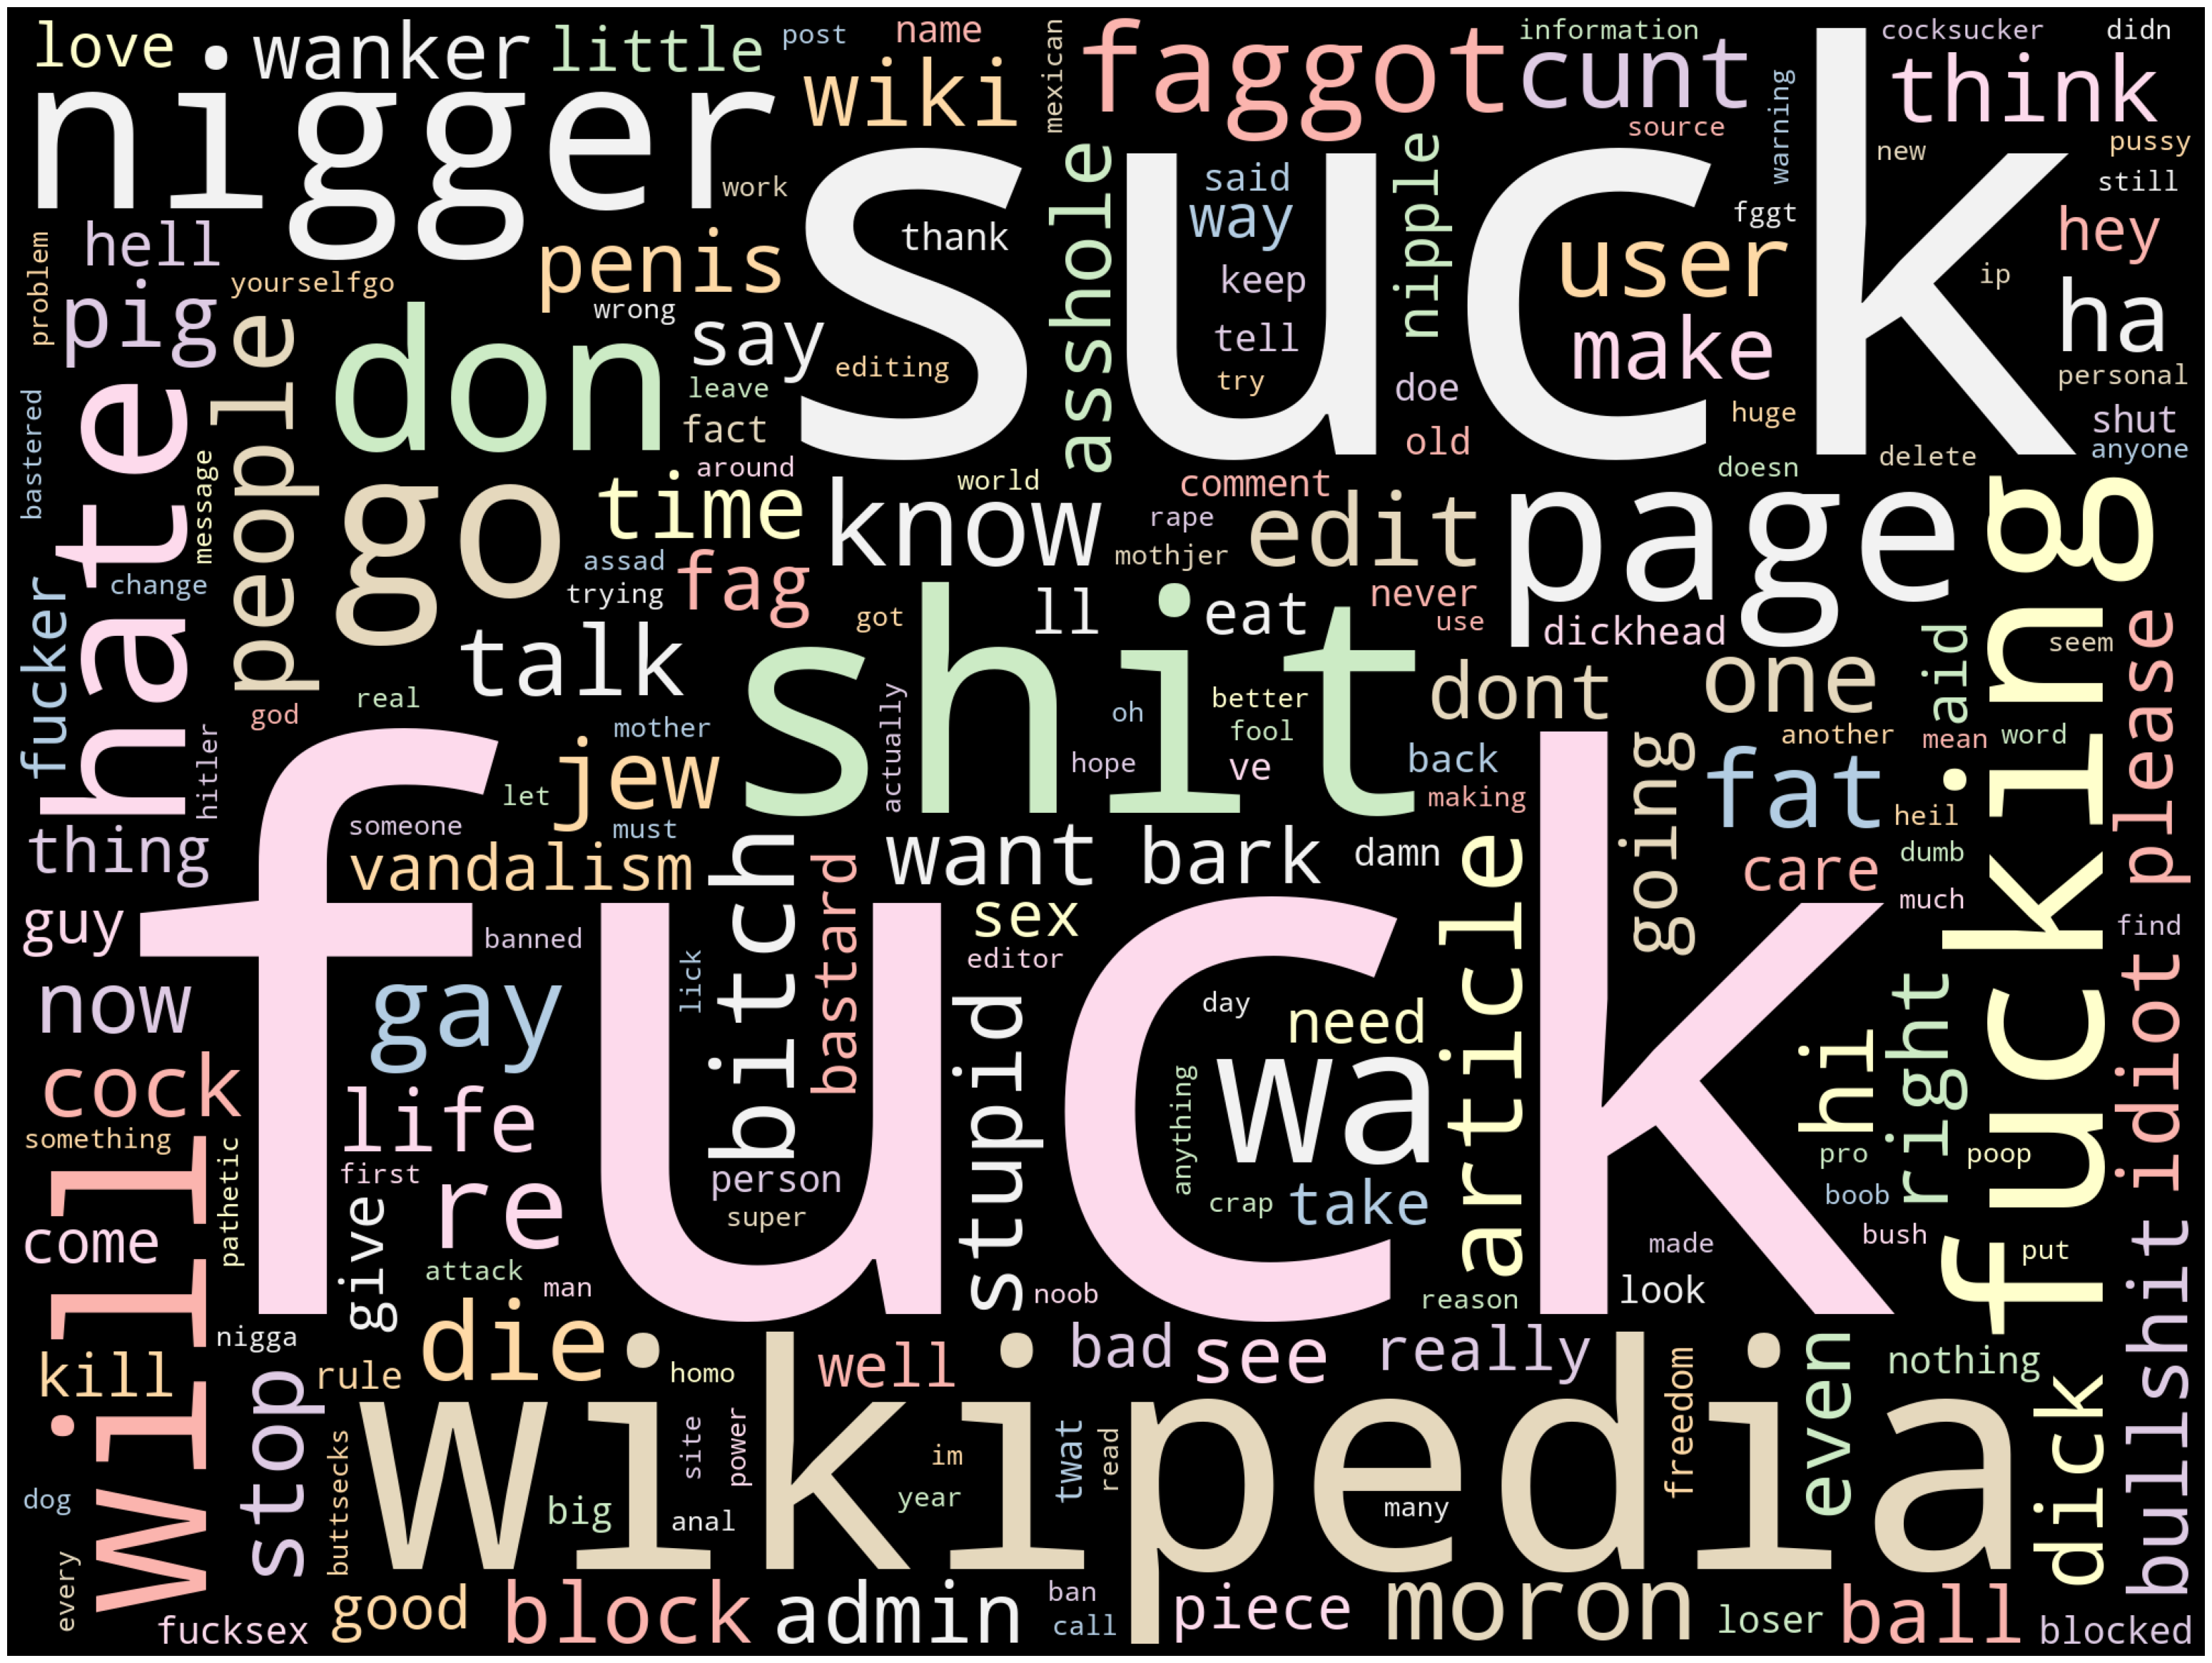

In [11]:
cloud_params(df.loc[df['toxic'] == 1])

Облако слов нетоксичных комментариев:

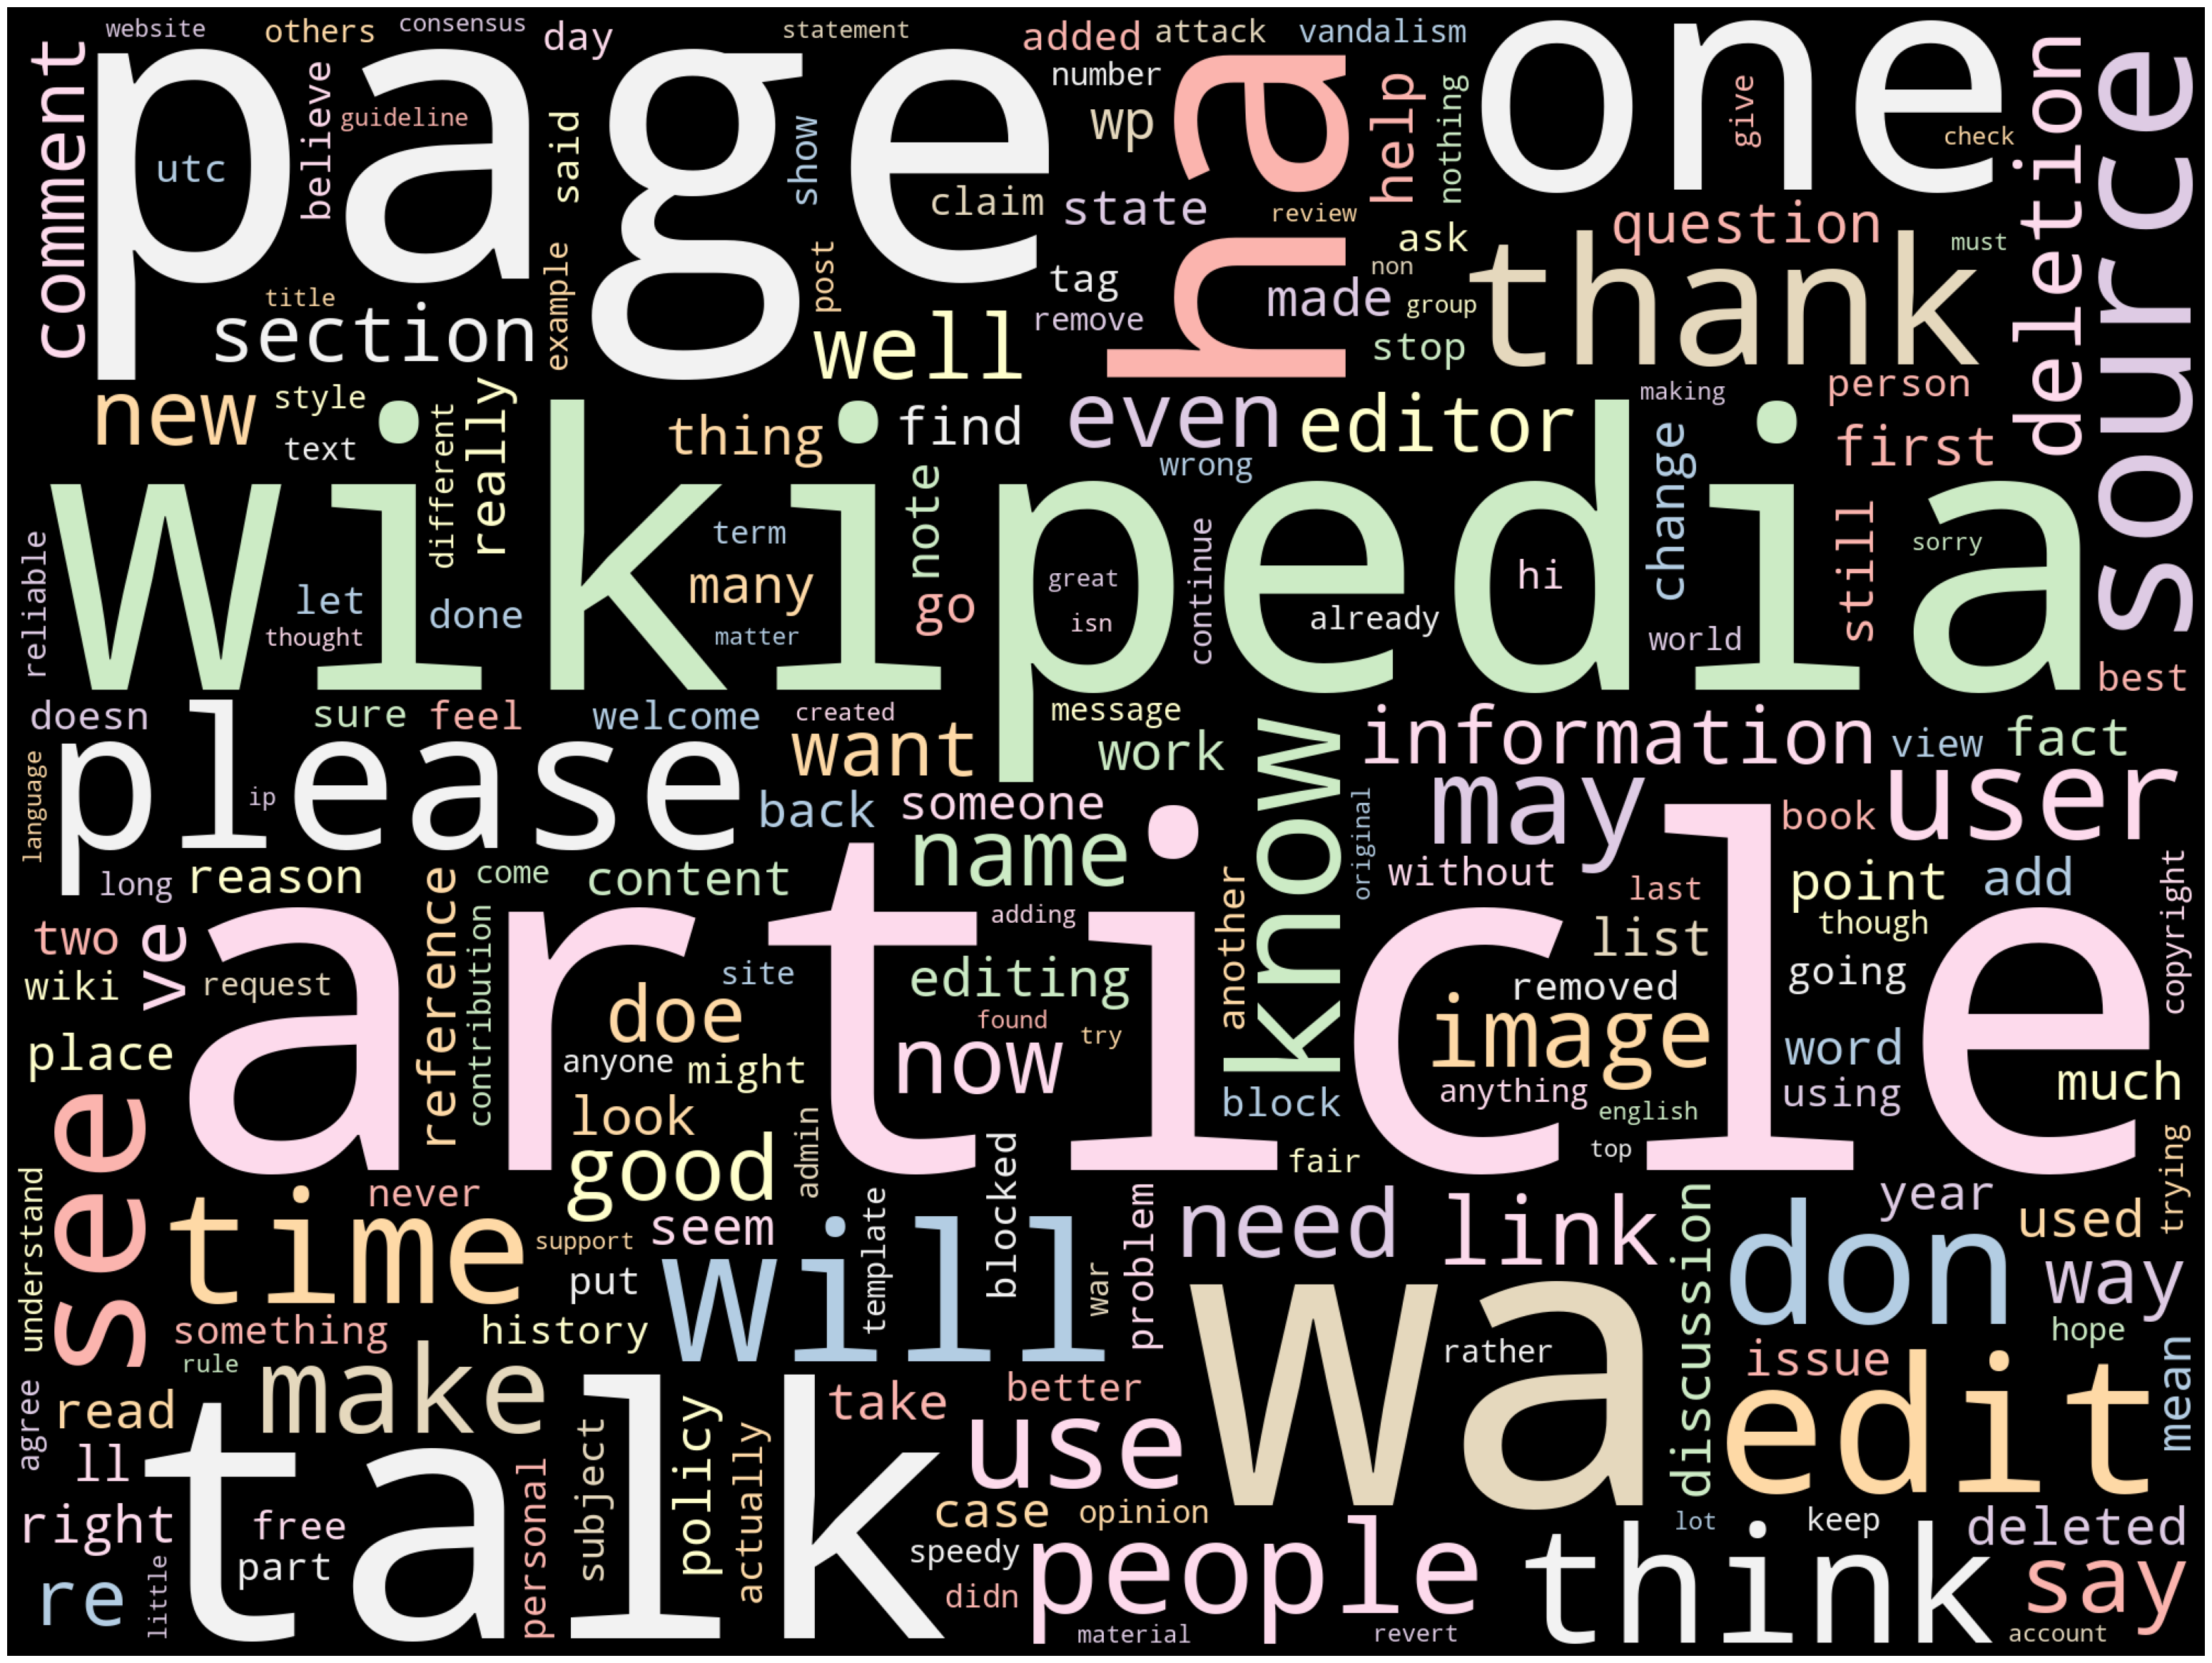

In [12]:
cloud_params(df.loc[df['toxic'] == 0])

**Вывод:**  
В тиксичных комментариях зачастую используется обсценная лексика: нецензурная брань, оскорбления по расовому и половому признаку и прочие слова, принижающие человеческое достоинство. Наиболее распространены слова "suck" и "fuck"  
В нетоксичных комментариях отсутствует обсценная лексика.  
Обе выборки объединяет слово "wikipedia".

## Подготовка данных
<a id="section_2"></a>

### Предобработка данных
<a id="section_2_1"></a>

После удаления всех символов, кроме буквенных (латиница), проверяем признак "text" на дубликаты:

In [13]:
print(f'Количество дублирующихся значений признака "text" - {df["text"].duplicated().sum()}.')

Удаляем дубликаты:

In [14]:
len_df_start = df.shape[0]
df = df.drop_duplicates()
print('Удалено дубликатов - {}'.format(len_df_start - df.shape[0]))

### Подготовка выборок
<a id="section_2_2"></a>

Задаем параметр random_state:

In [15]:
RS = 42
# RS = np.random.RandomState(5)

Отбираем 5000 наблюдений:

In [16]:
df_united = df.sample(n=5000, random_state=RS).reset_index(drop=True)

In [17]:
print('Доля токсичных комментариев - {:.3f}'.format(df_united["toxic"].sum()/df_united["toxic"].count()))

**Подготовка признака "text"**

Инициализируем автотокенизатор и автомодель для BERT:

In [18]:
model = ppb.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = ppb.AutoTokenizer.from_pretrained('unitary/toxic-bert')

Токенизируем значения признака "text":

In [19]:
# токенизируем признак
tokenized = df_united['text'].apply(
    lambda x: tokenizer.encode(x, padding=True, truncation=True,max_length=50, add_special_tokens = True))

max_len = 0
for i in tokenized.values:                                   # определяем максимальную длину признака
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])   # увеличиваем длину признаков до максимальной

attention_mask = np.where(padded != 0, 1, 0)                                # указываем нулевые и не нулевые значения                   

Преобразовываем в векторное представление:

In [20]:
batch_size = 64                                                                       # размер батча
embeddings = []                                                                        # список для векторов признаков
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):                          # выделяем батчи из выборки
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])                # преобразовываем данные в формат тензоров
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]) # преобразовываем данные в формат тензоров
        
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)           # получаем эмбеддинги для батча
        
        embeddings.append(batch_embeddings[0][:,0,:].detach().numpy())                          # добавляем батчи в список

Соберём все эмбеддинги в матрицу признаков:

In [21]:
features = np.concatenate(embeddings)
features = pd.DataFrame(features)

Выделяем из датафрейма целевой признак и оставляем только те значения, для которых признаки были добавлены в embeddings:

In [22]:
y = df_united['toxic']                                  # целевой признак
y = y[0:len(features)]

**Разделение выборки на обучающую и тестовую**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.4, stratify=y, shuffle=True)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [24]:
print('Размер обучающей выборки - {}.'.format(X_train.shape[0]))
print('Размер тестовой выборки - {}.'.format(X_test.shape[0]))

**Вывод:**  
1. Из значений признака "text" удалены все символы, кроме буквенных (латиница);
2. Удалены дубликаты, возникшие в результате предобработки;  
3. Значения признака "text" токенизированы и преобразованы в векторное представление;  
4. Удалено дубликатов - 1148;
5. Для обучения и проверки моделей отобрано 5000 наблюдений.
6. В отобранных данных присутствует дисбаланс классов: доля токсичных комментариев - 0.107.  
7. Размер обучающей выборки - 2995.  
   Размер тестовой выборки - 1997.

## Обучение моделей
<a id="section_3"></a>

Обучаем модели LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier. Дисбаланс классов учитывается при помощи метода взвешивания классов.

### Функции построения моделей
<a id="section_3_1"></a>

In [25]:
def metrics(model, params):
    '''функция обучения моделей и расчёта метрик'''
    optuna.logging.set_verbosity(optuna.logging.WARNING)                               # отключаем логгирование
    model = OptunaSearchCV(model, params, scoring='f1', cv=3)                     # передаем данные в OptunaSearchCV
    start_time = timeit.default_timer()                                                # начальное время обучения
    model.fit(X_train, np.ravel(y_train))                                              # обучаем модель
    time_fit = timeit.default_timer() - start_time                                     # длительность обучения
    f1 = model.best_score_
    print('F1: {}'.format(f1))
    return model, f1, time_fit

### Модель LogisticRegression
<a id="section_3_2"></a>

In [26]:
params_lr = {'C': intd(1, 10, False, 3)}                                     # значения гиперпараметров модели для подбора
model_lr = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=RS)      # создаем модель
best_model_lr, f1_lr, time_fit_lr = metrics(model_lr, params_lr)

### Модель DecisionTreeClassifier
<a id="section_3_3"></a>

In [27]:
params_dtc = {'min_samples_leaf' : intd(1, 9, False, 4),         # значения гиперпараметров модели для подбора
              'min_samples_split' : intd(2, 10, False, 4),
              'max_depth' : intd(1, 9, False, 4)}
model_dtc = DecisionTreeClassifier(class_weight='balanced', random_state=RS)               # создаем модель
best_model_dtc, f1_dtc, time_fit_dtc = metrics(model_dtc, params_dtc)

### Модель RandomForestClassifier
<a id="section_3_4"></a>

In [28]:
params_rfc = {'min_samples_leaf' : intd(1, 9, False, 4),                     # значения гиперпараметров модели для подбора
              'min_samples_split' : intd(2, 10, False, 4),
              'max_depth' : intd(1, 9, False, 4),
              'n_estimators' : intd(100, 140, False, 20)}
model_rfc = RandomForestClassifier(class_weight='balanced', random_state=RS)                   # создаем модель
best_model_rfc, f1_rfc, time_fit_rfc = metrics(model_rfc, params_rfc)

### Модель CatBoostClassifier
<a id="section_3_5"></a>

In [29]:
params_cb = {     
    'learning_rate' : floatd(0.01, 0.91, False, 0.9),                        # значения гиперпараметров модели для подбора
    'l2_leaf_reg': intd(4, 6, False, 2)
}
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
model_cb = CatBoostClassifier(verbose=False,                          # создаем модель
                             iterations = 1000,
                             class_weights=class_weights)
best_model_cb, f1_cb, time_fit_cb = metrics(model_cb, params_cb)

In [30]:
df_united_model = pd.DataFrame({'model' : ['LinearRegression',
                                    'DecisionTreeClassifier',
                                    'RandomForestClassifier',
                                    'CatBoostClassifier'],
                         'f1' : [f1_lr, f1_dtc, f1_rfc, f1_cb],
                         'time_fit' : [time_fit_lr, time_fit_dtc, time_fit_rfc, time_fit_cb],
                         'best_model' : [best_model_lr, best_model_dtc, best_model_rfc, best_model_cb]})
df_united_model[['model', 'f1', 'time_fit']]

Определяем лучшую модель по наибольшему значению F1:

In [31]:
best_model_row = df_united_model.loc[df_united_model['f1'] == df_united_model['f1'].max()]           # строка с данными по лучшей модели
best_model = best_model_row.iloc[0][3]                                                    # лучшая модель
print('Лучшая модель: {}'.format(best_model_row.iloc[0][0]))
print('F1 лучшей модели: {}'.format(best_model_row.iloc[0][1]))
print('Время обучения лучшей модели (секунд): {:.3f}'.format(best_model_row.iloc[0][2]))
print('Гиперпараметры лучшей модели: {}'.format(best_model.best_params_))

**Вывод:**  
1. Обучались следующие модели:
 - LinearRegression;
 - DecisionTreeRegressor;
 - RandomForestRegressor;
 - CatBoostClassifier;
2. Наилучшая модель по метрике F1 - CatBoostClassifier, обученная на выборке, сбалансированной методом взвешивания классов.  
    Метрики лучшей модели:  
 - F1 = 0.891;  
 - time_fit (время обучения) = 1019.711 сек.;
 
    Параметры лучшей модели:
 - learning_rate: 0.01;
 - l2_leaf_reg: 4.  

## Проверка лучшей модели
<a id="section_4"></a>

Проверяем лучшую модель на тестовой выборке:

In [32]:
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Метрика F1 на тестовой выборке - {:.3f}'.format(f1))
print('Метрика Recall на тестовой выборке - {:.3f}'.format(recall))

Строим матрицу ошибок:

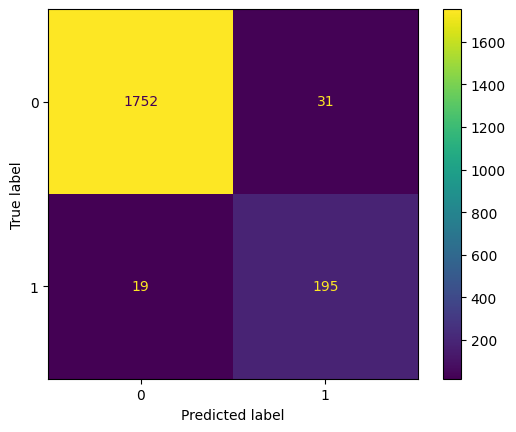

In [33]:
cm = confusion_matrix(y_test, y_pred)                                           # рассчитываем матрицу ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm)                              
disp.plot()                                                                     # визуализируем матрицу ошибок
plt.show()

**Вывод:**  
Метрика F1 для лучшей модели (CatBoostClassifier) - 0.886, что удовлетворяет требованию заказчика (нее менее 0.75).  
Recall - 0.911.

## Общий вывод
<a id="section_5"></a>

**Импорт данных и общая информация**  

1. Исходный датафрейм состоит из 159292 наблюдений и 3 признаков.  
2. Дублирование значений и пропуски отсутствуют.
3. Определено наличие дисбаланса классов: доля токсичных комментариев - 0.102; 


**Исследовательский анализ данных**  

В тиксичных комментариях зачастую используется обсценная лексика: нецензурная брань, оскорбления по расовому и половому признаку и прочие слова, принижающие человеческое достоинство. Наиболее распространены слова "suck" и "fuck"  
В нетоксичных комментариях отсутствует обсценная лексика.  
Обе выборки объединяет слово "wikipedia".


**Подготовка данных**

1. Из значений признака "text" удалены все символы, кроме буквенных (латиница);
2. Удалены дубликаты, возникшие в результате предобработки;  
3. Значения признака "text" токенизированы и преобразованы в векторное представление;  
4. Удалено дубликатов - 1148;
5. Для обучения и проверки моделей отобрано 5000 наблюдений.
6. В отобранных данных присутствует дисбаланс классов: доля токсичных комментариев - 0.107.  
7. Размер обучающей выборки - 2995.  
   Размер тестовой выборки - 1997.  


**Обучение моделей**  

1. Обучались следующие модели:
 - LinearRegression;
 - DecisionTreeRegressor;
 - RandomForestRegressor;
 - CatBoostClassifier;
2. Наилучшая модель по метрике F1 - CatBoostClassifier, обученная на выборке, сбалансированной методом взвешивания классов.  
    Метрики лучшей модели:  
 - F1 = 0.891;  
 - time_fit (время обучения) = 1019.711 сек.;
 
    Параметры лучшей модели:
 - learning_rate: 0.01;
 - l2_leaf_reg: 4.      
 

**Проверка лучшей модели**  

Метрика F1 для лучшей модели на тестовой выборке - 0.886, что удовлетворяет требованию заказчика (нее менее 0.75).  
Метрика Recall для лучшей модели на тестовой выборке - 0.911.